<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <style>
    .container {
      display: flex;
      flex-direction: row-reverse;
    }
    .text {
      flex: 1;
      text-align: justify;
    }
    .title {
      flex: 0;
      text-align: right;
      margin-left: 20px;
    }
  </style>
</head>
<body>
  <div class="container">
     <div class="title">
      <h1 dir="rtl">شرح سوال</h1>
    </div>
    <div class="text">
      <p dir="rtl">یکی از کابردهای الگوریتم‌های سرچ مانند الگوریتم beam search استفاده از آنها در مدل‌های encoder-decoder based است.
در این تمرین می‌خواهیم از یک نمونه از این مدل‌ها برای تولید text استفاده کنیم، به طور دقیق‌تر می‌خواهیم در این تمرین با استفاده از الگوریتم beam search یک response برای متن ورودی تولید کنیم.
در این تمرین شما به طور کلی به یادگیری شبکه عصبی نیازی ندارید و صرفاً کافی است با مطالعه تابع generate_text نحوه تعامل با مدل را یاد بگیرید که چگونه با مدل encoder و decoder که کد آن آماده است ارتباط گرفته یعنی به آن ورودی داده و از آن خروجی بگیرید و سپس تابع generate_text_with_beam_search را تکمیل کرده و در cell بعدی نمونه‌هایی از خروجی‌های آن را تولید کنید.
قبل از مطالعه این تابع بهتر است cell های مربوط به preprocess داده را هم بررسی کنید، برای ورودی دادن به شبکه عصبی لازم است که text ورودی را به صورت عددی به مدل بدهیم برای این منظور برای هر word یا token چه در input text ها یعنی text هایی که به عنوان ورودی در نظر می‌گیریم و چه در target text ها که به عنوان خروجی در نظر می‌گیریم  یک index یکتا در نظر می‌گیریم که آنها را به آن map می‌کنیم بنابراین قبل از اینکه text ورودی را به مدل ( هم encoder و هم decoder ) بدهیم آن‌ها را به برداری از index ها تبدیل می‌کنیم که همانطور که گفتیم یکتا است.
هنگام بررسی تابع generate_text به این موارد توجه کنید:
برای تولید response برای text ورودی آن را به برداری شامل index های هر word یا token تبدیل می‌کنیم و به تابع predict مدل encoder  می‌دهیم و states_value (hidden state و cell state) را به عنوان خروجی از آن میگیریم که به عنوان ورودی به مدل decoder بدهیم، در هر بار صدا زدن تابع predict مدل decoder، به عنوان ورودی آخرین token ای که تاکنون تولید شده است را به همراه آخرین states_value  به آن می‌دهیم (به فرمت داده شده دقت کنید)، به عنوان خروجی نیز از آن output_tokens که احتمال خروجی بودن هر token در آن هست  و همچنین hidden state و cell state را می‌گیریم و states_value را می‌سازیم و برای تولید word یا token بعدی از آنها استفاده می‌کنیم (دقت شود که این متن به دلیل عدم آشنایی شما با شبکه‌های عصبی و مدل های encoder-decoder به زبان ساده بیان شده است).
همچنین در ابتدای کار bos token را به عنوان token اولیه و states_value خروجی encoder را به decoder داده و token اولیه را تولید می‌کنیم و در ادامه هم به ترتیب گفته شده پیش می‌رویم.
در تابع generate_text به صورت greedy عمل شده است یعنی هر بار token با بیشترین احتمال را به عنوان token خروجی گرفته‌ایم.
<br>
در این تمرین از شما خواسته شده است که تابع generate_text_with_beam_search را پیاده‌سازی کنید، کافی است به صورت گفته شده در بالا و مشابه تابع generate_text که به صورت greedy کار می‌کند تابع گفته شده را پیاده کنید و اما در اینجا نباید به صورت greedy عمل کنید بلکه باید از الگوریتم beam search استفاده کنید یعنی در هر گام (تولید هر token یا word) همه token ها را در نظر گرفته و احتمالات را در هر گام محاسبه کرده و سپس با توجه به beam search width مرتب کنید و خروجی بگیرید.
</br>
برای اجرای کد بهتر است از google colab استفاده کنید و دیتاست داده شده را هم روی google drive خود قرار دهید و cell ها را اجرا کنید.
برای درک و شهود بهتر از سوال و عملکرد encoder-decoder ها و همچنین عملکرد greedy  و beam search تصاویری که در ادامه آمده است را ببینید.
همچنین می‌توانید به <a href="https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24" target="_blank">این لینک</a></h1> مراجعه کنید (البته دقت شود که تسک مطرح شده در این لینک مربوط به Machine translation است اما مدل‌ها مشابه هستند).
</p>
    </div>
  </div>
</body>
</html>


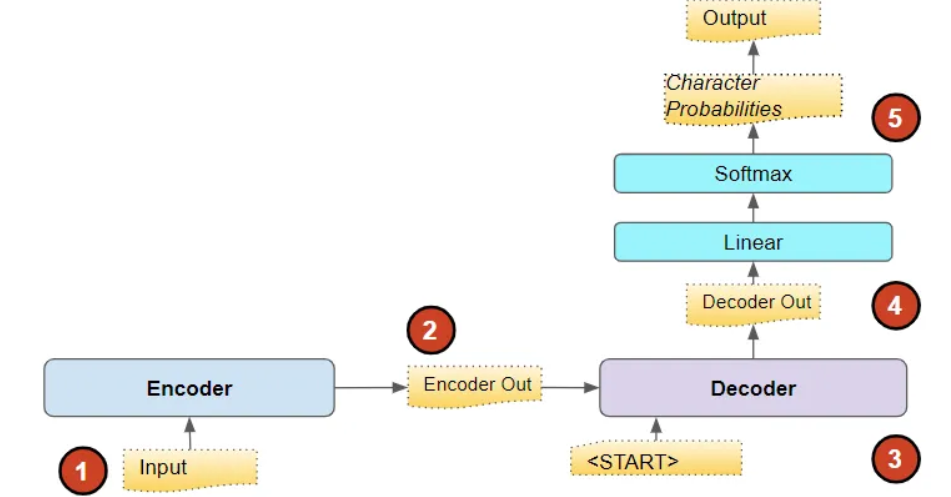

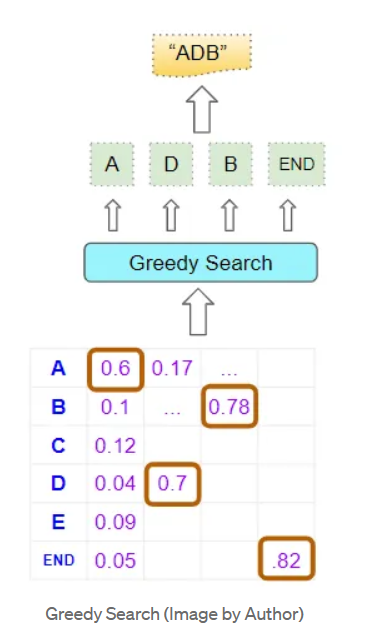

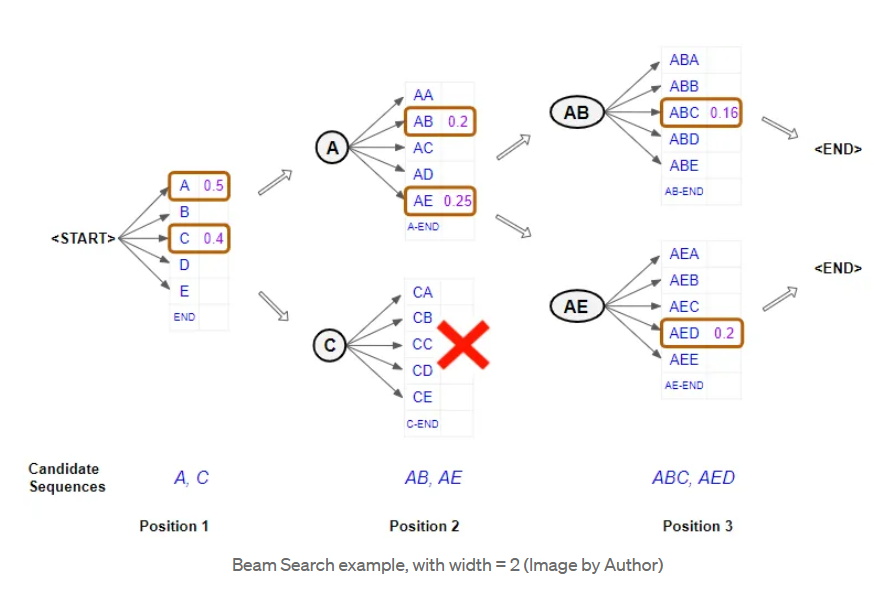

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from math import log
from google.colab import drive
from math import log

In [2]:
import tensorflow as tf

# Function to set up distributed training strategy
def setup_distributed_training():
    """
    Set up distributed training strategy for TPU or default strategy for CPU/GPU.

    Returns:
        tf.distribute.Strategy: The distributed training strategy.
    """
    try:
        # Check if TPU is available and configure the strategy accordingly
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Device:', tpu.master())
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print('Using TPU strategy.')
    except ValueError:
        # TPU is not available, fall back to CPU/GPU strategy
        strategy = tf.distribute.get_strategy()
        print('Using default strategy for CPU/GPU.')

    print('Number of replicas:', strategy.num_replicas_in_sync)
    return strategy

# Set up the distributed training strategy
strategy = setup_distributed_training()

# Set AUTOTUNE for optimizing performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

print('TensorFlow version:', tf.__version__)

Using default strategy for CPU/GPU.
Number of replicas: 1
TensorFlow version: 2.13.0


In [3]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
%cp /content/gdrive/MyDrive/topical_chat.csv /content/

In [5]:
batch_size = 64
epochs = 200
latent_dim = 512

In [6]:
# Read the dataset and handle errors
try:
    # Load the dataset
    df = pd.read_csv('/content/topical_chat.csv')[:160000]

    print('Length of dataset:', len(df))

    # Convert the 'message' column to string type
    df['message'] = df['message'].astype(str)

    # Display the first few rows of the dataset
    df.head()
except FileNotFoundError:
    print("Dataset file not found.")
except pd.errors.EmptyDataError:
    print("The dataset file is empty.")
except pd.errors.ParserError:
    print("Error occurred while parsing the dataset.")

Length of dataset: 160000


In [7]:
def preprocess_text(text):
    """
    Preprocesses the input text.

    Args:
        text (str): Input text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    # Convert to lowercase and replace specific characters
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    # Remove punctuation and extra spaces
    text = ''.join(char for char in text if char not in string.punctuation)
    text = ' '.join(text.split())

    return text

In [8]:
df.message = df.message.apply(preprocess_text)

In [9]:
print(len(df))
df.head()

160000


conversation_id                                            message  \
0                1               are you a fan of google or microsoft   
1                1  both are excellent technology they are helpful...   
2                1  im not a huge fan of google but i use it a lot...   
3                1  google provides online related services and pr...   
4                1  yeah their services are good im just not a fan...   

                sentiment  
0  Curious to dive deeper  
1  Curious to dive deeper  
2  Curious to dive deeper  
3  Curious to dive deeper  
4  Curious to dive deeper

In [10]:
# Initialize lists to store input and target texts
input_texts = []
target_texts = []

# Initialize sets to store unique words
input_words_set = set()
target_words_set = set()

# Iterate through the dataset to process conversations
for conversation_index in tqdm(range(1, len(df))):
    # Get the current and previous rows (messages in a conversation)
    current_row = df.iloc[conversation_index]
    previous_row = df.iloc[conversation_index - 1]

    # Check if the conversation IDs match
    if current_row['conversation_id'] == previous_row['conversation_id']:
        input_text = previous_row['message']
        target_text = current_row['message']

        # Check conditions for valid input and target texts
        if (2 < len(input_text.split()) < 30 and
            0 < len(target_text.split()) < 10 and
            input_text and target_text):

            # Add start and end tokens to the target text
            target_text = "bos " + target_text + " eos"

            # Append to input and target text lists
            input_texts.append(input_text)
            target_texts.append(target_text)

            # Update the sets of unique words
            input_words_set.update(input_text.split())
            target_words_set.update(target_text.split())

print("\nNumber of unique input words:", len(input_words_set))
print("Number of unique target words:", len(target_words_set))

100%|██████████| 159999/159999 [00:28<00:00, 5664.44it/s]


Number of unique input words: 11464
Number of unique target words: 6954


In [11]:
# Convert sets to sorted lists for consistency
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))

# Calculate various lengths and quantities
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max(len(txt.split()) for txt in input_texts)
max_decoder_seq_length = max(len(txt.split()) for txt in target_texts)

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

# Create token index dictionaries
input_token_index = {word: i for i, word in enumerate(input_words)}
target_token_index = {word: i for i, word in enumerate(target_words)}

# Initialize arrays for encoder and decoder data
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# Populate the arrays with token indices
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]

    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

print("Encoder Input Data shape:", encoder_input_data.shape)
print("Decoder Input Data shape:", decoder_input_data.shape)
print("Decoder Target Data shape:", decoder_target_data.shape)

Number of samples: 17179
Number of unique input tokens: 11464
Number of unique output tokens: 6954
Max sequence length for inputs: 29
Max sequence length for outputs: 11
Encoder Input Data shape: (17179, 29)
Decoder Input Data shape: (17179, 11)
Decoder Target Data shape: (17179, 11, 6954)


In [12]:
# Define constants and hyperparameters
embedding_size = 100

# Define encoder
with strategy.scope():
    encoder_inputs = keras.Input(shape=(None,))
    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
    encoder_lstm = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)
    encoder_states = [state_h, state_c]

# Define decoder
with strategy.scope():
    decoder_inputs = keras.Input(shape=(None,))
    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)  # Define decoder_embedding here
    decoder_embedding_output = decoder_embedding(decoder_inputs)
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
with strategy.scope():
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

# Training
with strategy.scope():
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=30, validation_split=0.1)

# Define the encoder model
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

# Define the decoder model
with strategy.scope():
    decoder_state_input_h = keras.Input(shape=(None,))
    decoder_state_input_c = keras.Input(shape=(None,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_embedding_output = decoder_embedding(decoder_inputs)

    decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            1146400   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            695400    ['input_2[0][0]']             
                                                                                              

In [13]:
# Reverse-lookup token index
reverse_input_token_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_token_index = dict((i, word) for word, i in target_token_index.items())

In [14]:
def generate_text(input_text, max_encoder_seq_length, input_token_index,
                      target_token_index, encoder_model, decoder_model,
                      reverse_target_token_index, max_response_length=50):
    """
    Generate a response based on the input text.
    Args:
        input_text (str): The input text to generate a response for.
        max_encoder_seq_length (int): Maximum length of the encoder sequence.
        input_token_index (dict): Dictionary mapping input words(tokens) to indices.
        target_token_index (dict): Dictionary mapping target words(tokens) to indices.
        encoder_model: The encoder model.
        decoder_model: The decoder model.
        reverse_target_token_index (dict): Dictionary mapping indices to target words(tokens).
        max_response_length (int): Maximum length of the generated response.
    Returns:
        str: The generated response.
    """
    input_seq = np.zeros((1, max_encoder_seq_length), dtype="float32")

    # Tokenize the input text and create the input sequence
    for t, word in enumerate(input_text.split()):
        # Convert words to their respective token indices
        input_seq[0, t] = input_token_index[word]

    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)
    # Initialize the target sequence with the start character
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['bos']  # 'bos' indicates the start of a sentence

    # Sampling loop to generate the response
    generated_sentence = ''
    for _ in range(max_response_length):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token by selecting the one with the highest probability (greedy method)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_token_index[sampled_token_index]

        # Exit condition: either hit max length or find the stop character
        if sampled_token == 'eos' or len(generated_sentence) > max_response_length:
            break
        else:
            generated_sentence += ' ' + sampled_token

        # Update the target sequence (of length 1) with the sampled token
        target_seq[0, 0] = sampled_token_index

        # Update the states for the next iteration
        states_value = [h, c]

    return generated_sentence


In [16]:
num_sequences_to_generate = 10

for seq_index in range(num_sequences_to_generate):
    input_text = input_texts[seq_index]
    generated_sentence = generate_text(input_text, max_encoder_seq_length,
                                        input_token_index, target_token_index,
                                        encoder_model, decoder_model,
                                        reverse_target_token_index)

    print("input sentence:", input_text)
    print("generated sentence:", generated_sentence)

1/1 [==============================] - 0s 31ms/step
input sentence: yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger
generated sentence:  i wonder if they can put elmo in the 1920s
1/1 [==============================] - 0s 30ms/step
input sentence: yes he even won a hardcore cha cha championship in 1958
generated sentence:  yeah do you know who invented the sport
1/1 [==============================] - 0s 26ms/step
input sentence: true did you know jackson had a patent on a dancing device
generated sentence:  yes that is a lot of money
1/1 [==============================] - 0s 21ms/step
input sentence: yes it helped him smooth out his dance moves
generated sentence:  nice chatting with you
1/1 [==============================] - 0s 22ms/step
input sentence: i wonder if they met how that would go from there
generated sentence:  yeah do you know who invented the sport
1/1 [==============================] - 0s 19ms/step
inpu

In [23]:
def generate_text_with_beam_search(input_text, number_of_words, beam_search_n,
                        max_encoder_seq_length, input_token_index, target_token_index,
                        encoder_model, decoder_model, reverse_target_token_index):
    """
    Generate text using beam search.
    Args:
        input_text (str): The initial text to start the generation.
        number_of_words (int): The number of words to generate.
        beam_search_n (int): Beam width for the search.
        max_encoder_seq_length (int): Maximum length of the encoder sequence.
        input_token_index (dict): Dictionary mapping input words(tokens) to indices.
        target_token_index (dict): Dictionary mapping target words(tokens) to indices.
        encoder_model: The encoder model.
        decoder_model: The decoder model.
        reverse_target_token_index (dict): Dictionary mapping indices to target_words.
    Returns:
        None
    """
    distributions_scores_states = [[list(), 1.0, [None, None]]]

    decoder_states_value = None

    for n in range(number_of_words):

        sequence_temp_candidates = list()

        for i in range(len(distributions_scores_states)):

            input_seq = np.zeros((1, max_encoder_seq_length), dtype="float32")

            target_seq = np.zeros((1, 1))

            seq, score, states_values = distributions_scores_states[i]

            if len(distributions_scores_states) == 1:
                for t, word in enumerate(input_text.split()):
                    input_seq[0, t] = input_token_index[word]

                decoder_states_value = encoder_model.predict(input_seq)
                target_seq[0, 0] = target_token_index['bos']

            else:
                target_seq[0, 0] = seq[-1]
                decoder_states_value = states_values

            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)

            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][0]

            for j in range(len(predicted_distribution)):
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score * predicted_distribution[j], decoder_states_value]
                    sequence_temp_candidates.append(candidate)

        ordered = sorted(sequence_temp_candidates, key=lambda tup: tup[1], reverse=True)
        distributions_scores_states = ordered[:beam_search_n]

        if n == number_of_words - 1:
          for w in range(beam_search_n):
            sequence, score, _ = distributions_scores_states[w]
            text = ""
            for index in sequence:
              if index == target_token_index['eos']:
                break
              generated_word = reverse_target_token_index[index]
              text += generated_word + " "
            print(text + ',  with score: ' + str(score))

In [24]:
num_sequences_to_generate = 5
number_of_words = 5
beam_search_n = 2

for seq_index in range(num_sequences_to_generate):
    input_text = input_texts[seq_index]
    print("input sentence:", input_text)
    generated_sentence = generate_text_with_beam_search(input_text, number_of_words, beam_search_n,
                        max_encoder_seq_length, input_token_index, target_token_index,
                        encoder_model, decoder_model, reverse_target_token_index)

input sentence: yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger
1/1 [==============================] - 0s 23ms/step
i wonder if he moved ,  with score: 0.0009432078299622584
i wonder if they can ,  with score: 0.0004081426733303044
input sentence: yes he even won a hardcore cha cha championship in 1958
1/1 [==============================] - 0s 20ms/step
yeah do you know who ,  with score: 0.015079432499271492
yeah do you know why ,  with score: 0.004333534483173657
input sentence: true did you know jackson had a patent on a dancing device
1/1 [==============================] - 0s 22ms/step
yes that is pretty cool ,  with score: 0.0006407894290385242
yes that is a lot ,  with score: 0.0005154675013612912
input sentence: yes it helped him smooth out his dance moves
1/1 [==============================] - 0s 22ms/step
nice chatting with you ,  with score: 0.017403782380749244
nice chatting with you too ,  with score: 0.001